# O cenário da cidade do Rio de Janeiro: rede escolar

- Continuando a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, ...

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np
from scipy import stats
from scipy.interpolate import interp2d

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

import pandas as pd

import rede_escolar

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../../..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 12/Jul/2020


## Distribuição populacional da cidade do Rio de Janeiro

Primeiramente, conforme feito anteriormente:

- posicionamos as residências;

- distribuímos os indivíduos em suas residências; e 

- posicionamos os indivíduos em torno de suas residências.

### Carregando os dados

Carregamos os dados populacionais por quilômetro quadrado da cidade do Rio de Janeiro obtidos do [Landscan](https://landscan.ornl.gov), mudando para 0 o valor das células com -1.

In [5]:
landscan_rio = np.load('../../../../dados/RJ/cidade_rj/dados_estatisticos/LandScan.npy').astype(int)
landscan_rio = np.maximum(landscan_rio, 0)

In [6]:
bairros_fino = np.load('geoloc_Bairros_MRJ_Fino.npy')

In [7]:
def refina_matriz(matriz, filtro):
    '''
    Refina uma matriz via interpolação linear e uma matriz fina como filtro.  
    '''
    matriz_fina = np.zeros_like(filtro)
    loc_sobra = list() 
    
    tx_refinamento_x = int(filtro.shape[1]/matriz.shape[1])
    tx_refinamento_y = int(filtro.shape[0]/matriz.shape[0])
    xs = list(range(matriz.shape[1]))
    ys = list(range(matriz.shape[0]))

    xs_fino = np.arange(0, matriz.shape[1], 1/tx_refinamento_x)
    ys_fino = np.arange(0, matriz.shape[0], 1/tx_refinamento_y)

    f = interp2d(xs, ys, matriz, kind='linear')
    matriz_interp = f(xs_fino, ys_fino)*np.minimum(filtro,1)

    for j in xs:
        for i in ys:
            if matriz[i,j]:
                matriz_interp_local \
                    = matriz_interp[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                    j*tx_refinamento_x:(j+1)*tx_refinamento_x]
                if matriz_interp_local.sum() == 0:
                    loc_sobra.append([i,j])
                else:
                    distrib = np.floor(matriz[i,j]*matriz_interp_local
                                           / matriz_interp_local.sum()
                                      ).astype('int')
                    sobra = matriz[i,j] - distrib.sum()
                    sobra_posicionamento \
                        = np.random.choice(tx_refinamento_x*tx_refinamento_y,
                                           int(sobra),
                                           replace=False,
                                           p=(matriz_interp_local
                                              /matriz_interp_local.sum()
                                             ).flatten()
                                          )
                    for loc in sobra_posicionamento:
                        distrib[loc // tx_refinamento_x,
                                loc % tx_refinamento_x] += 1
                    matriz_fina[i*tx_refinamento_y:(i+1)*tx_refinamento_y,
                                j*tx_refinamento_x:(j+1)*tx_refinamento_x] \
                        = distrib

    matriz_sobra = np.zeros_like(matriz)
    for ij in loc_sobra:
        matriz_sobra[ij[0], ij[1]] = matriz[ij[0], ij[1]]
    
    return matriz_fina, matriz_sobra

Carregamos os dados de escolas por quilômetro quadrado da cidade do Rio de Janeiro, obtidos do [IPP/Data Rio](https://www.data.rio/datasets/escolas-municipais)

In [8]:
modalidades = [2,3,5,6,7,15,21,30,35,42,105,210]
escolas_pub = np.array([np.load(f'mtrx_escolas/escolas_publicas_{m}.npy') for m in modalidades])
escolas_prv = np.array([np.load(f'mtrx_escolas/escolas_privadas_{m}.npy') for m in modalidades])

Por enquanto não faremos distinção entre a escola ser pública ou privada, para isto somaremos as duas matrizes

In [9]:
escolas = escolas_pub + escolas_prv

## Rede residencial

Montamos a rede residencial como antes.

O importante para a montagem da rede de empresas não é a rede residencial em si, apenas a localização dos indivíduos feita na construção da rede residencial.

### Reduzindo a população

Com o objetivo de realizar testes mais rápidos, com populações menores, dividimos a população de cada bloco por um determinado fator. 

Essa divisão nos dá números em ponto flutuante, que então truncamos para a sua parte inteira.

In [21]:
tx_reducao = 100

In [22]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
pop_por_blocos = (landscan_rio/tx_reducao).astype(int)

### Distribuindo e alocando os indivíduos e as suas residências

In [23]:
%%time
pos_residencias, pos_individuos, res_individuos, pop_blocos_indices \
    = episiming.cenarios.aloca_residencias_e_individuos(pop_por_blocos, censo_residencial)

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 431 ms


In [24]:
## Olhar essa função para otimizar tempo
num_pop = pop_por_blocos.sum()

piramide_etaria = pd.read_csv('../../../../dados/RJ/cidade_rj/dados_estatisticos/piramide_etaria_MRJ.csv')
idades_grupos = np.array([int(p[0:2]) for p in piramide_etaria.columns[1:]])
idades_grupos[-1] = 100
idades_fracoes_grupos = piramide_etaria.iloc[0][1:].values/piramide_etaria.iloc[0][0]

idade_max = 99

In [31]:
%%time
pop_idades = episiming.cenarios.gera_idades(len(pos_individuos), 8, res_individuos, idades_grupos, idades_fracoes_grupos, idade_max = 100)

CPU times: user 385 ms, sys: 3.51 ms, total: 389 ms
Wall time: 388 ms


In [40]:
def gera_idades(num_pop, num_tam_res, res_individuos, idades_fracoes):

    # separa as residências por tamanho
    res = (num_tam_res+1)*[[]]
    for j in range(1,num_tam_res+1):
        # seleciona residências com j indivíduos (res[0]=[])
        res[j] = [r for r in res_individuos if len(r) == j]
    # separa as residências com um adulto e um menor:
    res_2b = random.sample(res[2], k=int(0.1*len(res[2])))
    # separa as residências com dois adultos:
    res_2a = [r for r in res[2] if r not in res_2b]
    # agrega as residências com três ou mais indivíduos:
    res_3mais = []
    for res_k in res[3:]:
        res_3mais += res_k

    # separa a pirâmide populacional
    idades = list(range(len(idades_fracoes)))

    distrib_idades_adultos = num_pop*idades_fracoes
    distrib_idades_adultos[:20] = 0

    distrib_idades_menores = num_pop*idades_fracoes
    distrib_idades_menores[20:] = 0

    # inicializa lista de idades
    pop_idades = np.zeros(num_pop).astype(int)

    # define a idade dos adultos morando sozinhos
    ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res[1]))
    for j in range(len(res[1])):
        pop_idades[res[1][j]] = ind_idades[j]
        distrib_idades_adultos[ind_idades[j]] -= 1

    # define a idade do único adulto em residências com um adulto e um menor
    ind_idades = random.choices(idades, distrib_idades_adultos, k=len(res_2b))
    for j in range(len(res_2b)):
        pop_idades[res_2b[j][0]] = ind_idades[j]
        distrib_idades_adultos[ind_idades[j]] -= 1

    # define a idade de dois adultos nas outras residências com dois 
    # indivíduos
    len_res_2a = len(res_2a)
    ind_idades = random.choices(idades, distrib_idades_adultos,
                                k=2*len_res_2a)
    for j in range(len_res_2a):
        pop_idades[res_2a[j][0]] = ind_idades[j]
        pop_idades[res_2a[j][1]] = ind_idades[len_res_2a + j]
        distrib_idades_adultos[ind_idades[j]] -= 1
        distrib_idades_adultos[ind_idades[len_res_2a + j]] -= 1

    # define a idade de dois adultos nas residências com três ou mais 
    # indivíduos
    len_res_3mais = len(res_3mais)
    ind_idades = random.choices(idades, distrib_idades_adultos,
                                k=2*len_res_3mais)
    for j in range(len_res_3mais):
        pop_idades[res_3mais[j][0]] = ind_idades[j]
        pop_idades[res_3mais[j][1]] = ind_idades[len_res_3mais + j]
        distrib_idades_adultos[ind_idades[j]] -= 1
        distrib_idades_adultos[ind_idades[len_res_3mais + j]] -= 1

    # define a idade dos menores de idade em residências com um adulto 
    # e um menor
    len_res_2b = len(res_2b)
    ind_idades = random.choices(idades, distrib_idades_menores, k=len_res_2b)
    for j in range(len_res_2b):
        pop_idades[res_2b[j][1]] = ind_idades[j]
        distrib_idades_menores[ind_idades[j]] -= 1
    
    # calcula a distribuição restante de idades
    distrib_idades_left = np.array(
        [distrib_idades_menores[j] + distrib_idades_adultos[j] 
        for j in range(len(idades_fracoes))]
        )

    # define a idade do restante dos invidívuos em residências de três 
    # ou mais indivíduos
    for k in range(3,num_tam_res+1):
        ind_idades = random.choices(idades, distrib_idades_left,
                                    k=(k-2)*len(res[k]))
        for j in range(len(res[k])):
            for l in range(2, k):
                pop_idades[res[k][j][l]] = ind_idades[(l-2)*len(res[k]) + j]
                distrib_idades_left[ind_idades[(l-2)*len(res[k]) + j]] -= 1

    return pop_idades

In [44]:
idades_grupos

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,
        95, 100])

In [45]:
%%time
pop_idades_2 = gera_idades(len(pos_individuos), 10, res_individuos, idades_grupos)

CPU times: user 388 ms, sys: 39 µs, total: 388 ms
Wall time: 388 ms


(array([ 776.,  785.,  767.,  778.,  798.,  832.,  827.,  845.,  852.,
         929., 1039.,  989.,  994.,  990.,  988., 1022.,  993.,  995.,
         990.,  672., 1083., 1098., 1090., 1068., 1141., 1216., 1226.,
        1204., 1187., 1195., 1131., 1116., 1108., 1153., 1163.,  968.,
        1017., 1018., 1021., 1026.,  949.,  977.,  954.,  942.,  958.,
         925.,  950.,  925.,  949.,  959.,  836.,  901.,  916.,  860.,
         867.,  771.,  763.,  756.,  751.,  787.,  590.,  609.,  607.,
         643.,  607.,  433.,  455.,  448.,  453.,  445.,  366.,  383.,
         376.,  352.,  365.,  273.,  285.,  274.,  271.,  287.,  194.,
         196.,  196.,  187.,  199.,  100.,   89.,  110.,   90.,   88.,
          34.,   28.,   35.,   35.,   38.,    8.,   10.,    6.,   10.,
          12.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.

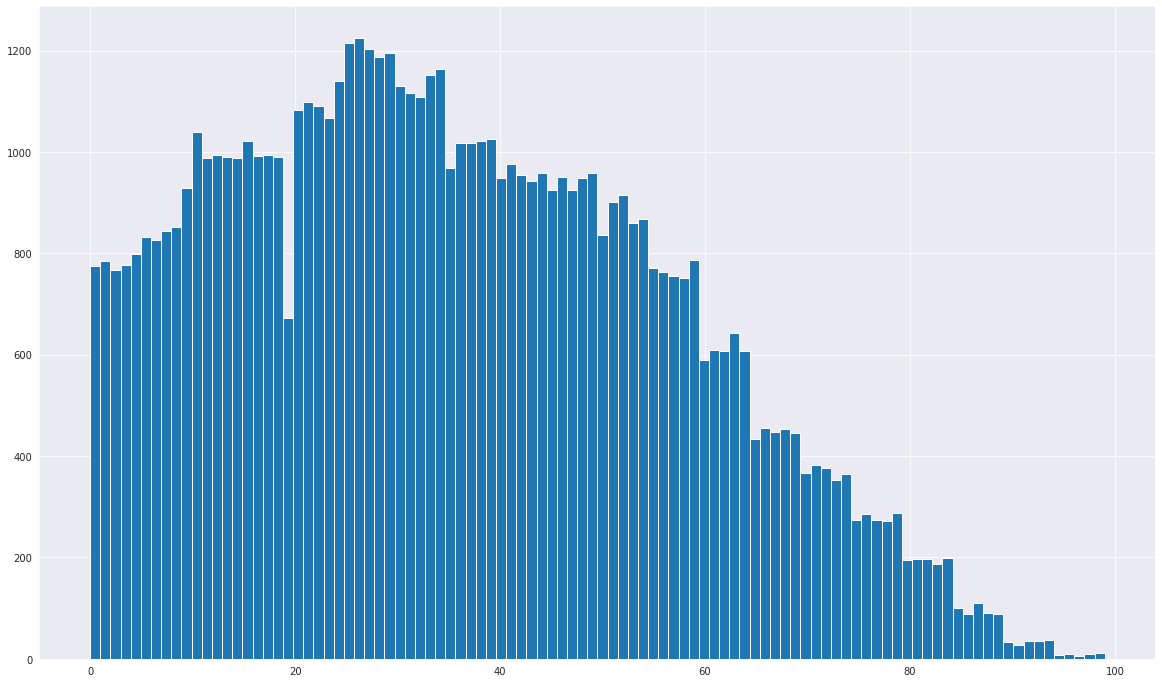

In [46]:
plt.figure(figsize = (20,12))
plt.hist(pop_idades, bins = 100)

In [48]:
idades_fracoes = episiming.cenarios.obtem_idades_fracoes(idades_grupos, idades_fracoes_grupos)

AttributeError: module 'episiming.cenarios' has no attribute 'obtem_idades_fracoes'

(array([   8.,    0.,   32.,    0.,    0.,   59.,    0.,   77.,    0.,
           0.,   97.,    0.,  100.,    0.,    0.,  121.,    0.,  133.,
           0.,    0.,  173.,    0.,    0.,  155.,    0.,  184.,    0.,
           0.,  236.,    0.,  249.,    0.,    0.,  221.,    0.,  237.,
           0.,    0.,  291.,    0.,    0.,  302.,    0.,  324.,    0.,
           0.,  350.,    0., 1217.,    0.,    0., 1183.,    0., 1270.,
           0.,    0., 1335.,    0., 1401.,    0.,    0., 1438.,    0.,
           0., 1769.,    0., 1945.,    0.,    0., 2390.,    0., 2692.,
           0.,    0., 2777.,    0., 3245.,    0.,    0., 3478.,    0.,
           0., 3761.,    0., 4109.,    0.,    0., 4344.,    0., 4625.,
           0.,    0., 4900.,    0., 5322.,    0.,    0., 5494.,    0.,
        5929.]),
 array([ 1.  ,  1.39,  1.78,  2.17,  2.56,  2.95,  3.34,  3.73,  4.12,
         4.51,  4.9 ,  5.29,  5.68,  6.07,  6.46,  6.85,  7.24,  7.63,
         8.02,  8.41,  8.8 ,  9.19,  9.58,  9.97, 10.36, 10.

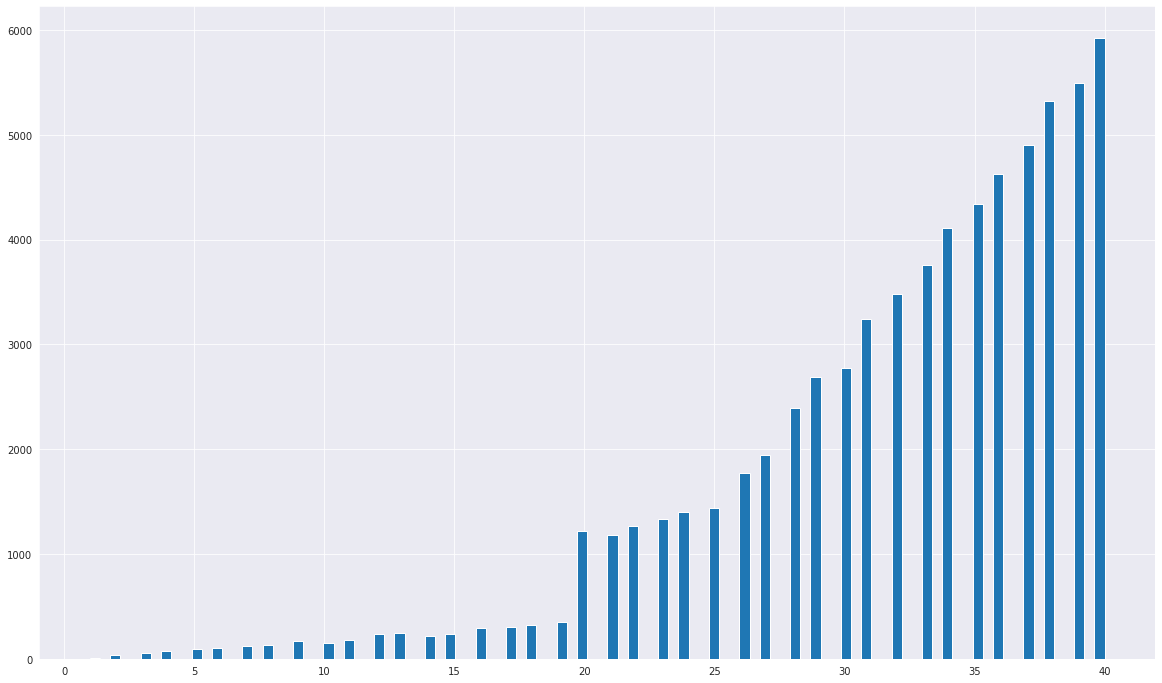

In [47]:
plt.figure(figsize = (20,12))
plt.hist(pop_idades_2, bins = 100)

Fazendo a interpolação para o refinamento da malha

In [32]:
def corrige_mtrx(mtrx, tipo = 0):
    if tipo == 0:
        new_mtrx = np.zeros(np.shape(mtrx))
        for i in range(39):
            new_mtrx[np.abs(i-38)] = mtrx[i]
    else:
        new_mtrx = np.zeros(np.shape(mtrx))
        for i in range(390):
            new_mtrx[np.abs(i-380)] = mtrx[i]
    return new_mtrx

In [33]:
mtrx_escolas_reduzida = np.array([refina_matriz(i, bairros_fino)[0] for i in escolas_reduzida])

In [34]:
np.sum(mtrx_escolas_reduzida)

1358.0

#### Heatmaps das escolas por modalidade - cenário completo

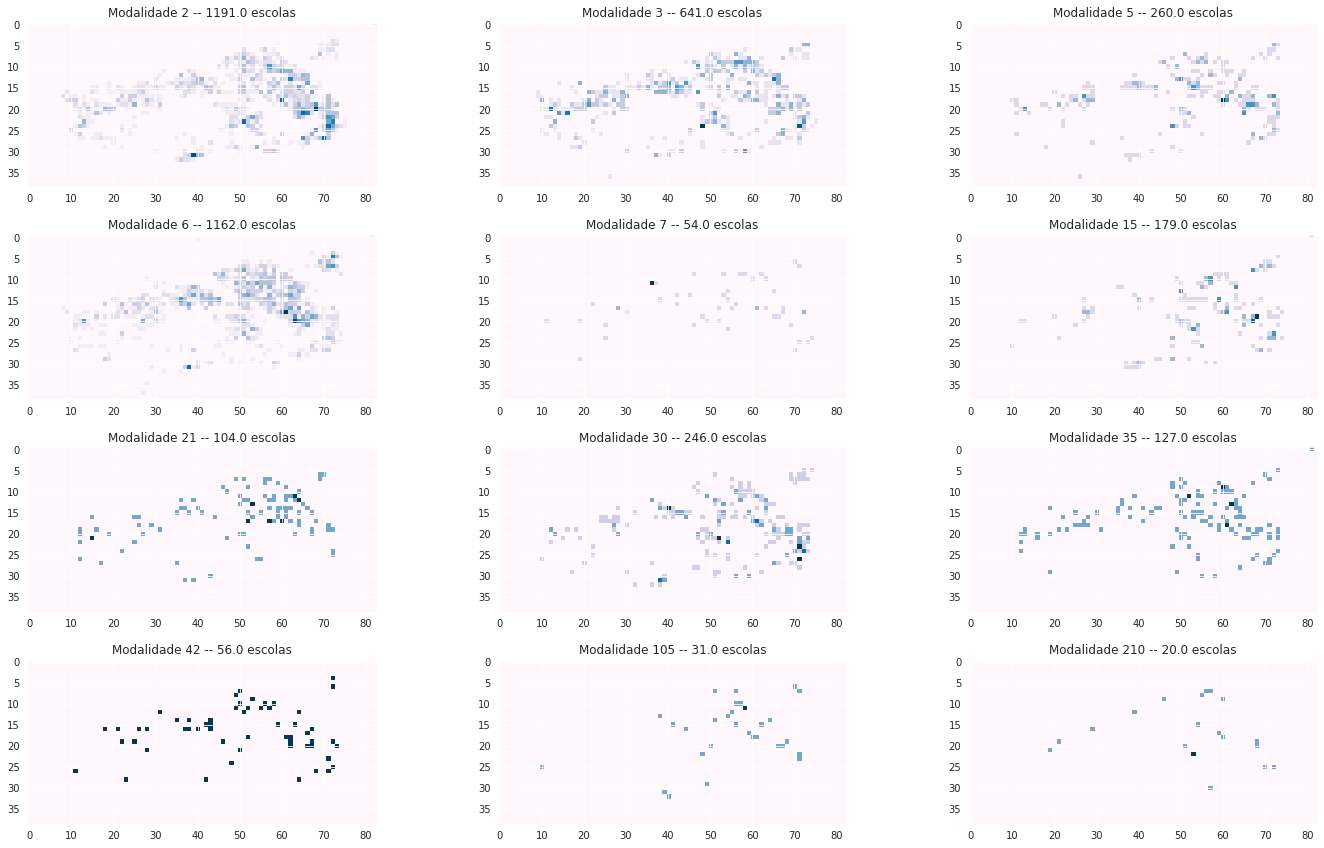

Total de 4071.0 escolas


In [35]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize = (20,12))

for i,row in enumerate(ax):
    for j,col in enumerate(row):
        col.imshow(escolas[j+3*i], cmap = 'PuBu')
        col.set_title(f'Modalidade {modalidades[j+3*i]} -- {np.sum(escolas[j+3*i])} escolas')
fig.tight_layout(pad=1.5)
plt.show()
print(f'Total de {np.sum(escolas)} escolas')

#### Heatmaps das escolas por modalidade - cenário reduzido

In [39]:
# np.save('pop_idades_tx3',pop_idades)

In [40]:
def dist_idade_modalidade(idade_max, grupos_idade_escolar, dist_grupos_idade):
    """Função que calcula a quantidade de matriculas por idade e modalidade escolar, segundo censo

    Args:
        idade_max (int): Idade max da população do cenário
        grupos_idade_escolar (array): Array com a separação de idades por grupo, onde cada par de elementos
        representa um intervalo do tipo [a,b)
        dist_grupos_idade (array): Array com a distribuição de cada grupo de idades, segundo censo.
        Pode ser passado apenas um array com a distribuição, ou um array de arrays com distribuição
        que representa a distribuição por modalidades

    Returns:
        array: Array com matrizes de tamanho 100, representando a quantidade total de cada idade de aluno em 
        uma modalidade
    """
    
    ## Caso seja passado somente um array em dist_grupos_idade
    if len(dist_grupos_idade.shape) < 2:
        dist_grupos_idade = np.array([dist_grupos_idade])
    
    ## Matriz com a distribuição de idade, separado idade a idade
    dist_idade = np.zeros((len(dist_grupos_idade),idade_max))
    
    ## Transforma a informação de distribuição por grupo de idade para distribuição por idade
    for j in range(len(dist_grupos_idade)):
        for i in range(len(grupos_idade_escolar)):
            if i < len(dist_grupos_idade[j]):
                dist_idade[j][grupos_idade_escolar[i]:grupos_idade_escolar[i+1]] = dist_grupos_idade[j][i]
                
    ## Calcula a quantidade de alunos na idade, por modalidade
    dist_idade_pop = np.array([np.count_nonzero(pop_idades == i) for i in range(idade_max)])
    dist_idade_escolar = np.round(dist_idade[:grupos_idade_escolar[-2]]*dist_idade_pop)
    return dist_idade_escolar

In [42]:
grupos = np.array([0, 4, 6, 15, 20, 100])

In [43]:
fracoes_grupos_2 = np.array([0.14666667, 0.40888889, 0.        , 0.        , 0.        ])
fracoes_grupos_3 = np.array([0.        , 0.        , 0.25569862, 0.        , 0.        ])
fracoes_grupos_5 = np.array([0.        , 0.        , 0.        , 0.23945578, 0.        ])
fracoes_grupos_6 = np.array([0.14346756, 0.39997017, 0.45939074, 0.        , 0.        ])
fracoes_grupos_7 = np.array([0.        , 0.        , 0.        , 0.        , 0.00673317])
fracoes_grupos_15 = np.array([0.        , 0.        , 0.07249391, 0.16689342, 0.        ])
fracoes_grupos_21 = np.array([0.        , 0.        , 0.04097482, 0.        , 0.01296758])
fracoes_grupos_30 = np.array([0.0303915 , 0.08472782, 0.09731519, 0.22403628, 0.        ])
fracoes_grupos_35 = np.array([0.        , 0.        , 0.        , 0.11882086, 0.01633416])
fracoes_grupos_42 = np.array([0.00689038, 0.01920955, 0.02206336, 0.        , 0.00698254])
fracoes_grupos_105 = np.array([0.        , 0.        , 0.0137896 , 0.03174603, 0.00436409])
fracoes_grupos_210 = np.array([0.00258389, 0.00720358, 0.00827376, 0.01904762, 0.00261845])

fracoes_grupos = np.array([fracoes_grupos_2,fracoes_grupos_3,fracoes_grupos_5,fracoes_grupos_6,fracoes_grupos_7,
                          fracoes_grupos_15,fracoes_grupos_21,fracoes_grupos_30,fracoes_grupos_35,fracoes_grupos_42,
                          fracoes_grupos_105,fracoes_grupos_210])

In [44]:
%%time
qt_idade_modalidade = dist_idade_modalidade(idade_max, grupos, fracoes_grupos)

CPU times: user 169 ms, sys: 61 µs, total: 170 ms
Wall time: 170 ms


In [45]:
def escolhe_alunos_idade(pop_idades, idades_na_escola):
    """Função que escolhe uma quantidade de individuos na população, pela idade, para serem matriculados
    em alguma escola

    Args:
        pop_idades (list(int)): Uma lista da idade de cada invididuo na população
        idades_escola (list(int)): Uma lista com a distribuição de alunos por idade

    Returns:
        array: Array com os indices dos alunos na população, separados pela distribuição de idade
    """
    alunos_modalidade = []
    for j in range(len(idades_na_escola)):
        alunos = np.array([np.random.permutation(np.arange(len(pop_idades))[pop_idades == i])[:int(idades_na_escola[j][i])] for i in range(len(idades_na_escola[j]))])
        alunos_modalidade.append(alunos)
    return np.array(alunos_modalidade)

In [46]:
%%time
alunos = escolhe_alunos_idade(pop_idades, qt_idade_modalidade)

CPU times: user 6.84 s, sys: 69.7 ms, total: 6.91 s
Wall time: 6.93 s


In [48]:
def gera_pos_escolas(mtrx_escolas):
    """Função que gera as escolas, indexando pela sua posição

    Args:
        mtrx_escolas (array): Lista com heatmaps de escolas por modalidade

    Returns:
        array: Lista com a posição de cada escola, por modalidade
    """
    
    pos_escolas_modalidade = []
    rng = np.arange(np.prod(mtrx_escolas[0].shape))
    for m in mtrx_escolas:
        qt_por_pos = m[m > 0].astype(int)
        pos = rng[m.flatten() > 0]
        aux = []
        for p,q in zip(pos,qt_por_pos):
            for i in range(q):
                aux.append((np.mod(p,m.shape[1]), p//m.shape[1]))
        pos_escolas_modalidade.append(aux)
    return pos_escolas_modalidade

In [49]:
pos_escolas_modalidade = gera_pos_escolas(mtrx_escolas_reduzida)

In [50]:
def aloca_alunos(alunos, pos_escolas, pos_individuos):
    """Função que aloca um aluno em uma das 3 escolas mais próximas de sua posição

    Args:
        alunos (array): Array com os indices dos alunos na população, separados pela distribuição de idade,
        este input é o output da função escolhe_aluno_idades
        pos_escolas (array): Lista com a posição de cada escola, por modalidade, este input é o
        output da função gera_pos_escolas

    Returns:
        array: Indice de alunos na população, separados por modalidade de escola
    """
    
    matriculas_modalidade = [[ [] for _ in range(len(p))] for p in pos_escolas]
    for i in range(len(alunos)):

        alunos_modalidade = np.hstack(alunos[i])
        pos_alunos_modalidade = np.array(pos_individuos)[alunos_modalidade]*10
        dist_aluno_esc = [np.linalg.norm(p_i - pos_escolas[i], axis = 1).argsort()[:3] for p_i in pos_alunos_modalidade if len(pos_escolas[i]) > 0]
        matricula = [random.choices(k)[0] for k in dist_aluno_esc]
        for k in range(len(matricula)):
            matriculas_modalidade[i][matricula[k]].append(alunos_modalidade[k])
            
    return matriculas_modalidade

In [58]:
3908/3

1302.6666666666667

In [59]:
print(f'Total de escolas no cenário: {np.sum(mtrx_escolas_reduzida)}')

Total de escolas no cenário: 1358.0


In [57]:
%%time
l = aloca_alunos(alunos, pos_escolas_modalidade, pos_individuos)

CPU times: user 47 s, sys: 439 ms, total: 47.5 s
Wall time: 47.7 s


In [60]:
dist_tam_escolas = np.sum([[len(i) for i in j] for j in l])

In [61]:
np.sum(dist_tam_escolas)*3

1735647

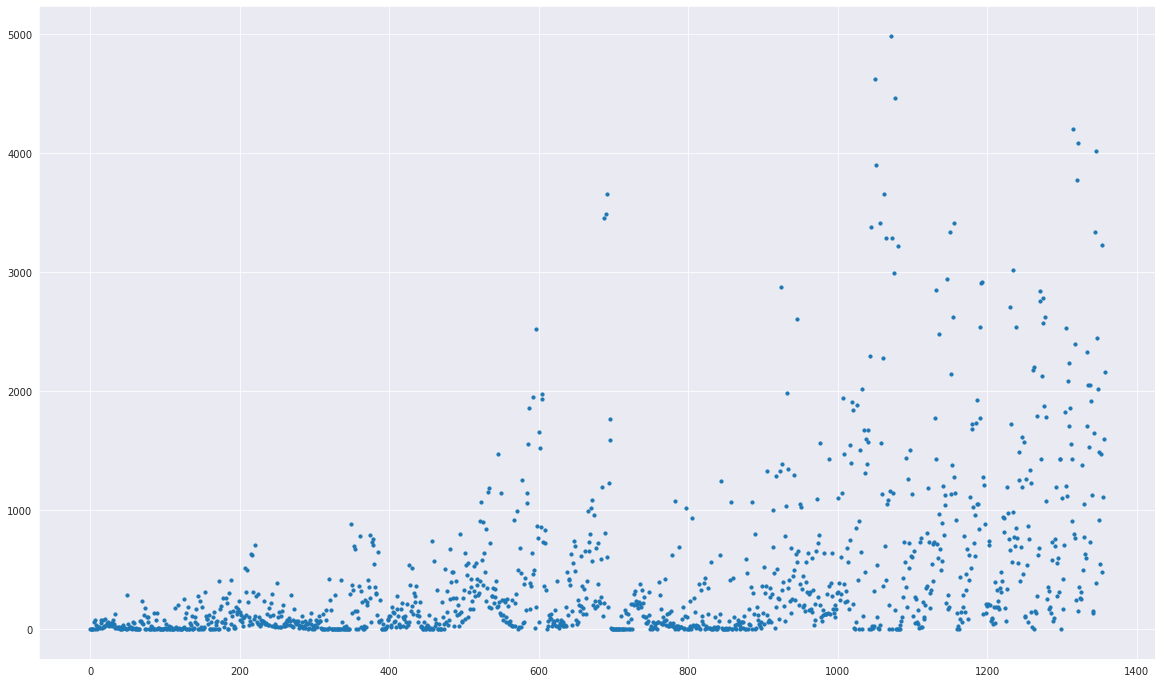

In [62]:
plt.figure(figsize = (20,12))
plt.scatter(np.arange(len(dist_tam_escolas)),dist_tam_escolas, s = 10, cmap = 'YlOrRd')

(array([578., 183., 118.,  86.,  53.,  36.,  43.,  48.,  15.,  17.,  21.,
         21.,  16.,   9.,  13.,  12.,   8.,  10.,   6.,   8.,   5.,   4.,
          3.,   2.,   3.,   5.,   3.,   3.,   3.,   3.,   2.,   0.,   3.,
          4.,   3.,   1.,   2.,   1.,   0.,   1.,   2.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.  ,   99.68,  199.36,  299.04,  398.72,  498.4 ,  598.08,
         697.76,  797.44,  897.12,  996.8 , 1096.48, 1196.16, 1295.84,
        1395.52, 1495.2 , 1594.88, 1694.56, 1794.24, 1893.92, 1993.6 ,
        2093.28, 2192.96, 2292.64, 2392.32, 2492.  , 2591.68, 2691.36,
        2791.04, 2890.72, 2990.4 , 3090.08, 3189.76, 3289.44, 3389.12,
        3488.8 , 3588.48, 3688.16, 3787.84, 3887.52, 3987.2 , 4086.88,
        4186.56, 4286.24, 4385.92, 4485.6 , 4585.28, 4684.96, 4784.64,
        4884.32, 4984.  ]),
 <a list of 50 Patch objects>)

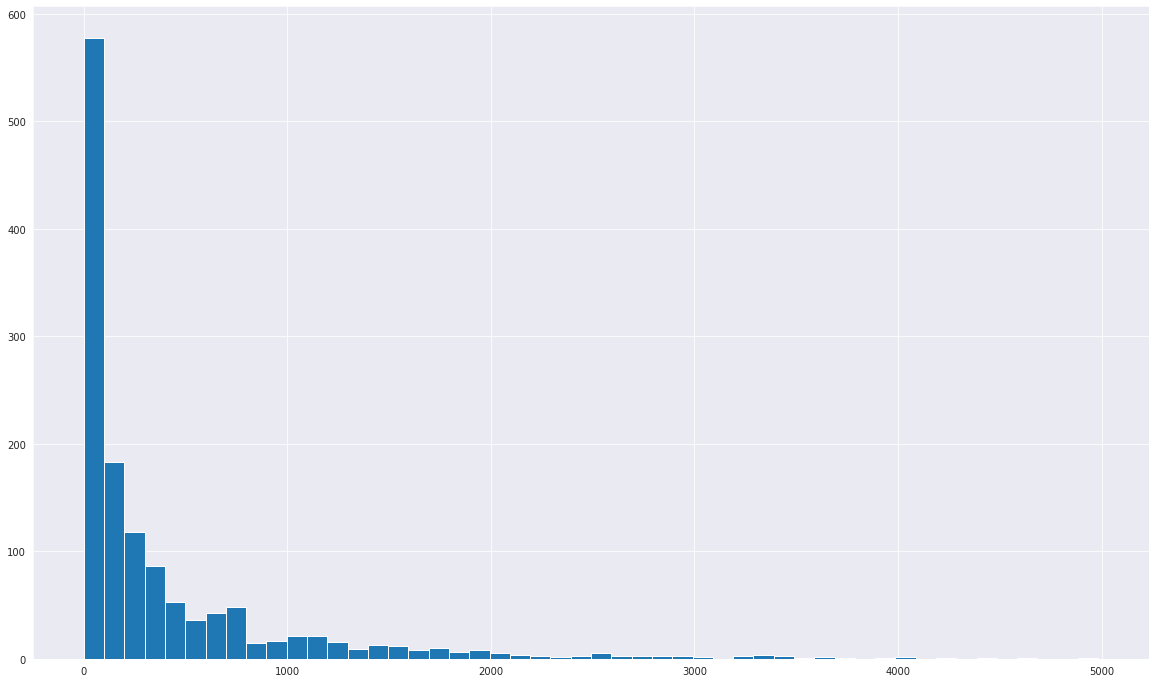

In [64]:
plt.figure(figsize = (20,12))
plt.hist(dist_tam_escolas, bins = 50)

In [ ]:
# attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

In [ ]:
# G_esc = nx.random_geometric_graph(num_pop, 0, pos = attrib_pos_individuos)

In [ ]:
# for modalidade in l:
#     for escola in modalidade:
#             G_esc.add_edges_from([(i,j) for i in escola for j in escola if i < j])

In [ ]:
# %%time
# plt.figure(figsize=(12,6))
# nx.draw(G_esc, pos=attrib_pos_individuos, node_size=1, alpha=0.5)
# plt.show()